# Laboratorium 8. Wizja Komputerowa

**Uwaga:** Poniższy notebook jest stworzony z myślą o uruchamianiu go w [Colaboratory](https://colab.research.google.com/), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania pracy domowej.

In [1]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


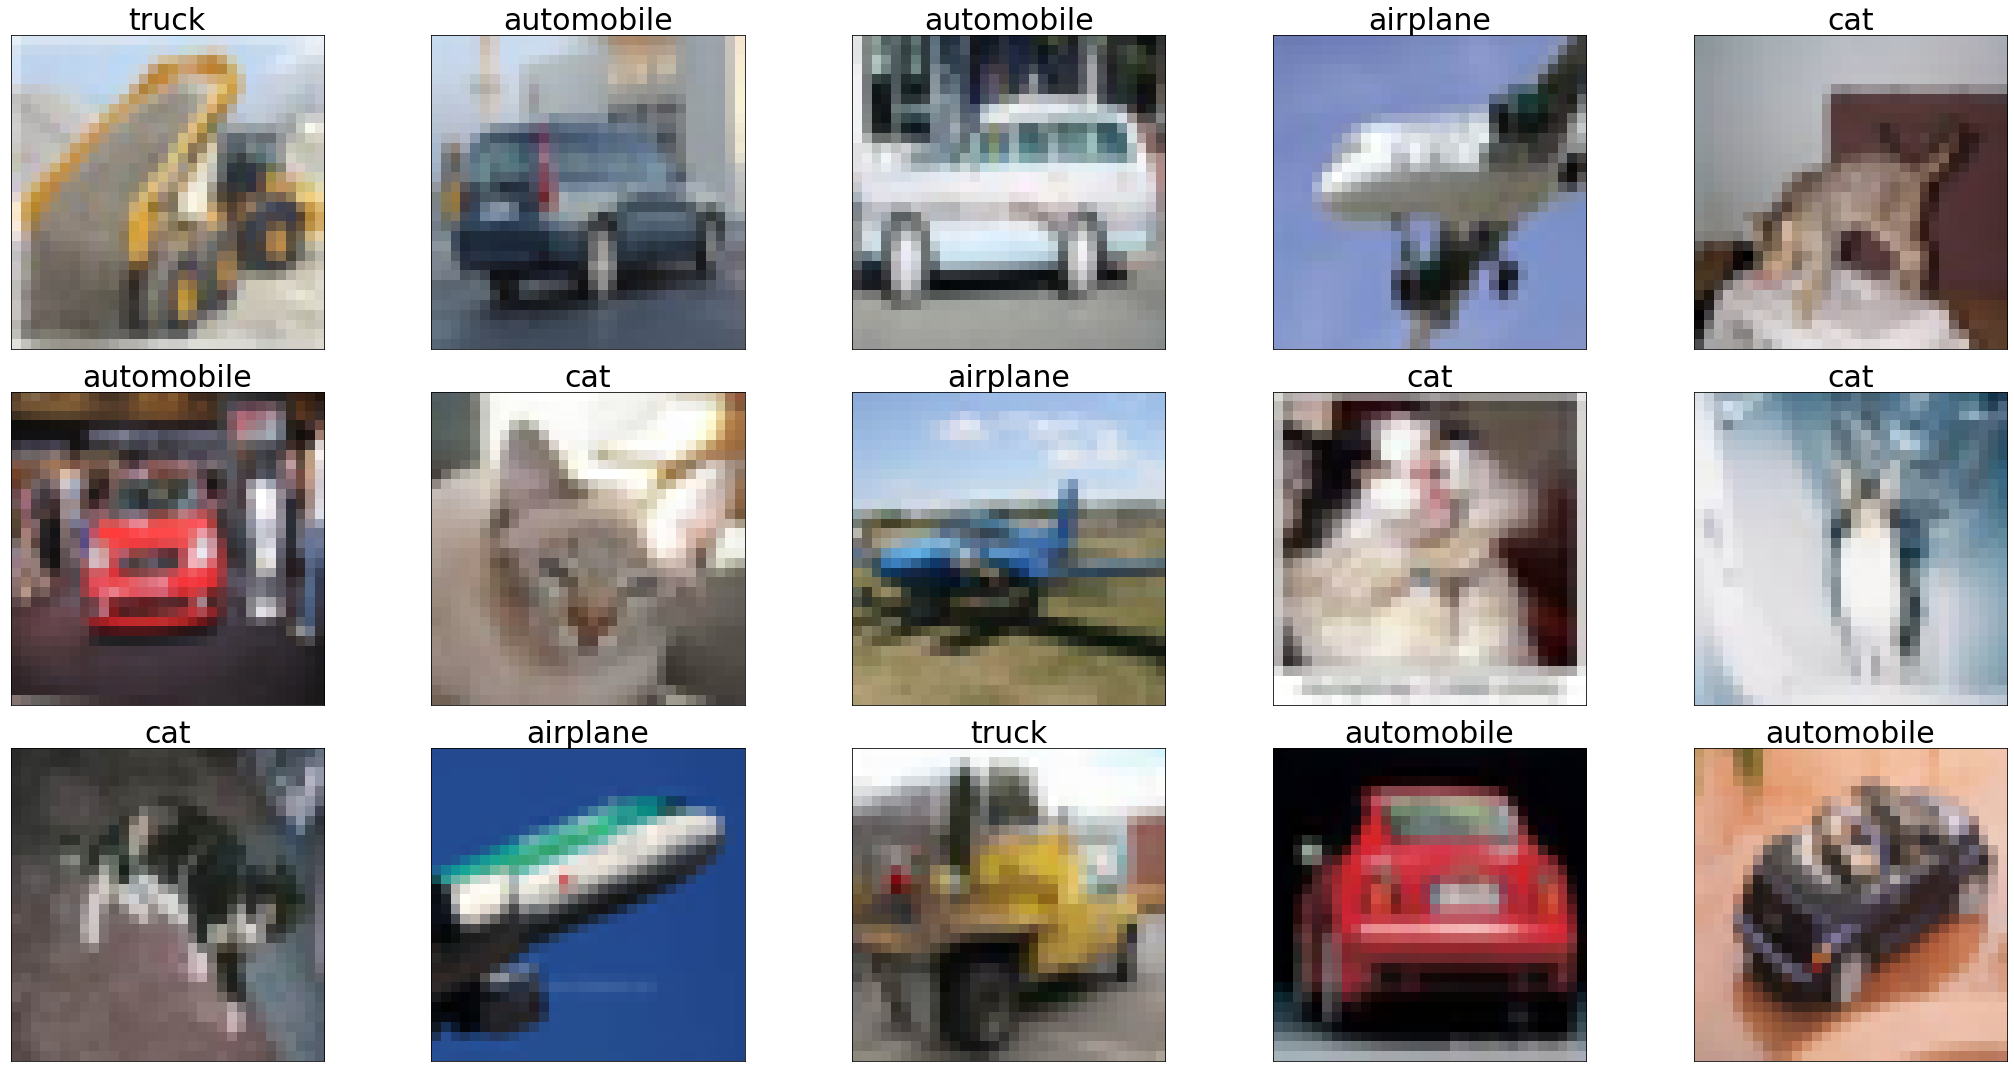

In [2]:
dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={'size': 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 1. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch_size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [11]:
print(torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

True


In [12]:
# tutaj zdefiniuj swój model, nie zapomnij o dziedziczeniu z torch.nn.Module
class CNN(torch.nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 5)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)
  
    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
# tutaj uzupełnij ładowanie danych treningowych i testowych

transforms = Compose(
    [ToTensor(),
     Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=transforms)

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=transforms)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
# tutaj zaimplementuj pętle uczenia ze wszystkimi potrzebnymi hiperparametrami
model = CNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [21]:
epochs = 15

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss_train = 0.0
    num_batches_train = 0
    running_loss_test = 0.0
    num_batches_test = 0
    running_corrects = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item()
        num_batches_train += 1
    with torch.no_grad():
      for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        running_loss_test += loss.item()
        num_batches_test += 1
        running_corrects += torch.sum(preds == labels.data)
        
    print("Epoch {0} train loss: {1:.3f}".format(epoch + 1, running_loss_train / num_batches_train))
    print("Epoch {0} test loss: {1:.3f}".format(epoch + 1, running_loss_test / num_batches_test))
    print("Epoch {0} test acc: {1:.3f}".format(epoch + 1, running_corrects / num_batches_test))

Epoch 1 train loss: 1.707
Epoch 1 test loss: 1.659
Epoch 1 test acc: 51.322
Epoch 2 train loss: 1.619
Epoch 2 test loss: 1.575
Epoch 2 test acc: 54.488
Epoch 3 train loss: 1.558
Epoch 3 test loss: 1.528
Epoch 3 test acc: 56.737
Epoch 4 train loss: 1.509
Epoch 4 test loss: 1.508
Epoch 4 test acc: 58.064
Epoch 5 train loss: 1.469
Epoch 5 test loss: 1.445
Epoch 5 test acc: 60.923
Epoch 6 train loss: 1.429
Epoch 6 test loss: 1.397
Epoch 6 test acc: 63.701
Epoch 7 train loss: 1.395
Epoch 7 test loss: 1.364
Epoch 7 test acc: 64.972
Epoch 8 train loss: 1.363
Epoch 8 test loss: 1.334
Epoch 8 test acc: 66.629
Epoch 9 train loss: 1.336
Epoch 9 test loss: 1.303
Epoch 9 test acc: 68.340
Epoch 10 train loss: 1.310
Epoch 10 test loss: 1.288
Epoch 10 test acc: 68.964
Epoch 11 train loss: 1.289
Epoch 11 test loss: 1.276
Epoch 11 test acc: 69.322
Epoch 12 train loss: 1.262
Epoch 12 test loss: 1.236
Epoch 12 test acc: 71.673
Epoch 13 train loss: 1.240
Epoch 13 test loss: 1.212
Epoch 13 test acc: 72.685


## Augmentacje

Pakiet `torchvision` implementuje wiele różnych transformacji do danych, część z nich jest użyteczna do tzw. augmentacji danych. Augmentacja danych to mechanizm "sztucznego" zwiększania datasetu treningowego poprzez dodawanie do niego zmodyfikowanych kopii danych, które już w nim istnieją. Augmentacja jest szczególnie użyteczna kiedy nasz dataset ma małą liczbę przykładów do uczenia skomplikowanych sieci neuronowych. 

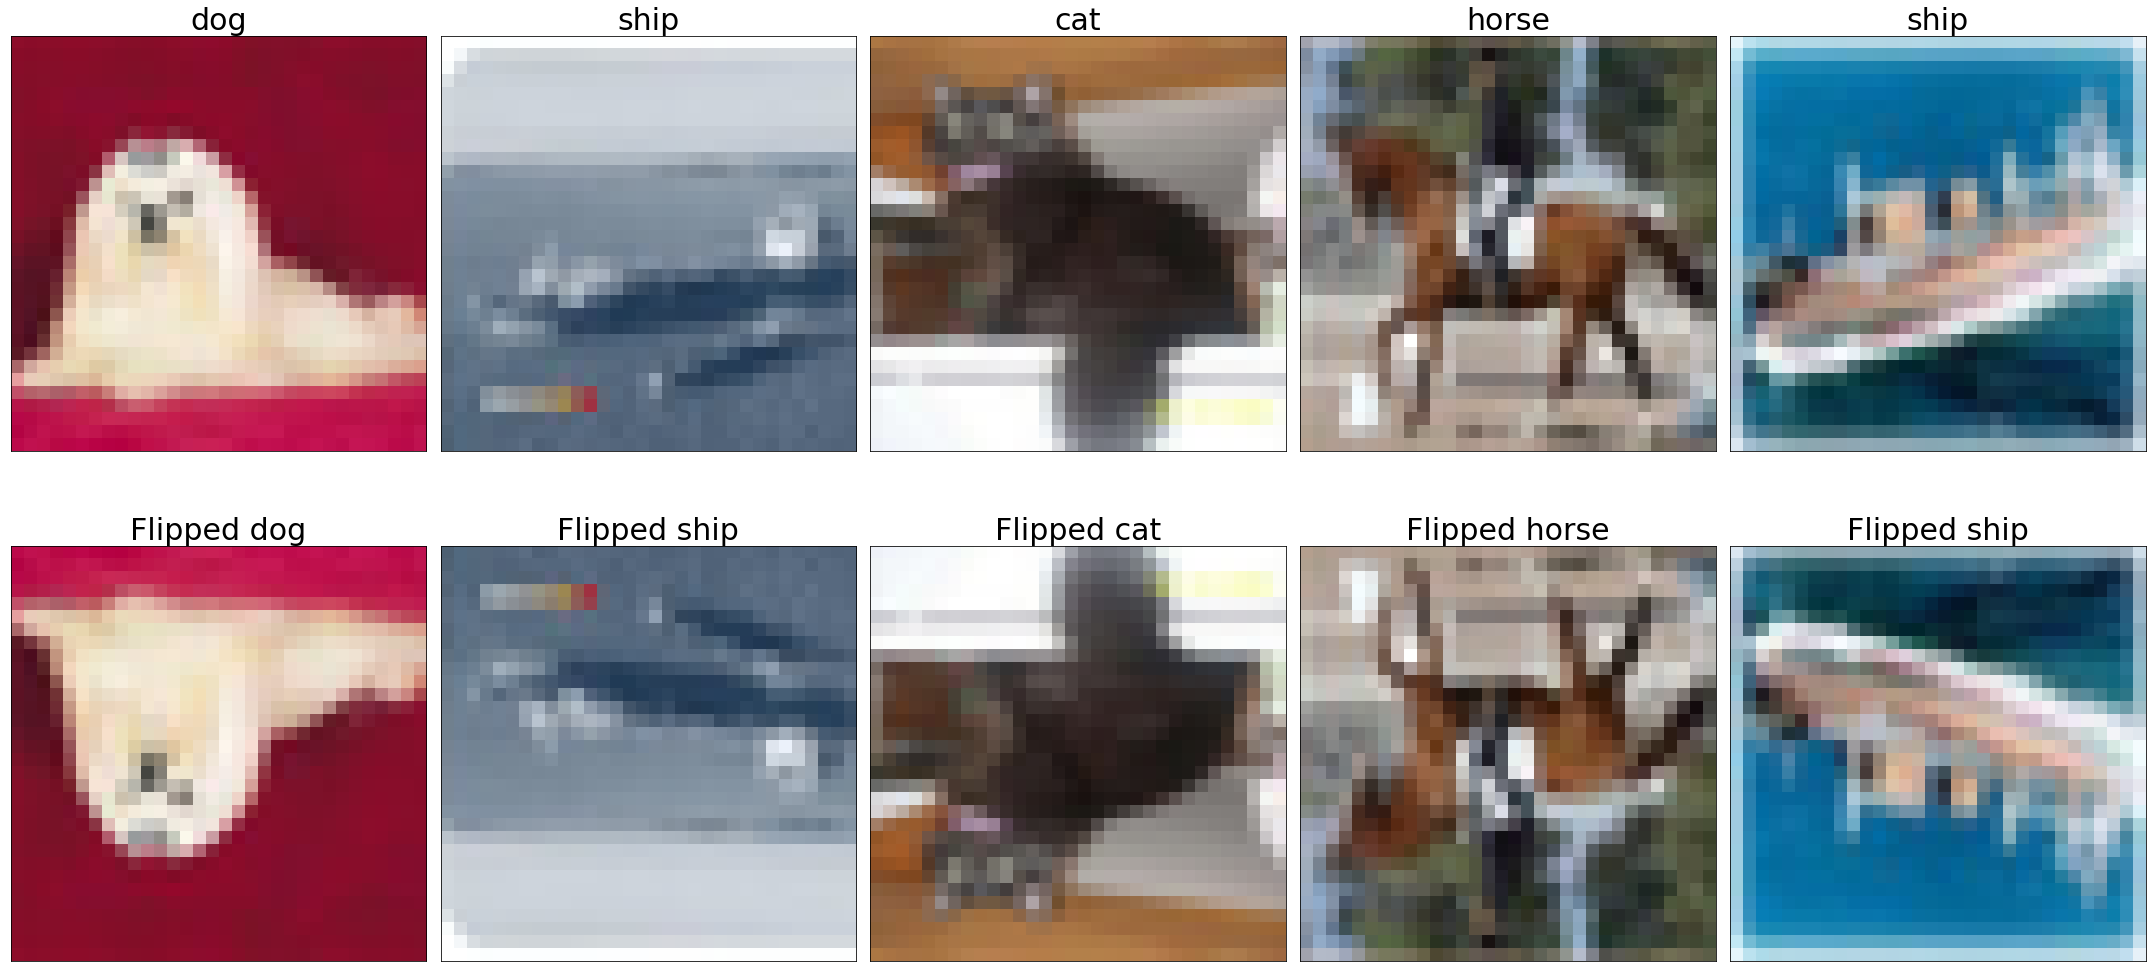

In [ ]:
from torchvision.transforms import RandomVerticalFlip

# load test set
dataset = CIFAR10(root='.', train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1) 

# load some data
for x, y in loader:
    break
    

# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])
    
for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

### Zadanie 2. Augmentacja danych (1 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twojego modelu z poprzedniego zadania. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

In [25]:
# tutaj dodaj wybrane augumentcje danych treningowych i załaduj testowe
from torchvision.transforms import transforms

transform_train = Compose([transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)) #Normalize all the images
                               ])

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=transform_train)

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=transforms)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [26]:
# tutaj powtórz pętle uczenia z poprzedniego zadania
model = CNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 15

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss_train = 0.0
    num_batches_train = 0
    running_loss_test = 0.0
    num_batches_test = 0
    running_corrects = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item()
        num_batches_train += 1
    with torch.no_grad():
      for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        running_loss_test += loss.item()
        num_batches_test += 1
        running_corrects += torch.sum(preds == labels.data)
        
    print("Epoch {0} train loss: {1:.3f}".format(epoch + 1, running_loss_train / num_batches_train))
    print("Epoch {0} test loss: {1:.3f}".format(epoch + 1, running_loss_test / num_batches_test))
    print("Epoch {0} test acc: {1:.3f}".format(epoch + 1, running_corrects / num_batches_test))

Epoch 1 train loss: 2.293
Epoch 1 test loss: 2.270
Epoch 1 test acc: 20.619
Epoch 2 train loss: 2.186
Epoch 2 test loss: 2.085
Epoch 2 test acc: 30.565
Epoch 3 train loss: 1.995
Epoch 3 test loss: 1.920
Epoch 3 test acc: 39.100
Epoch 4 train loss: 1.865
Epoch 4 test loss: 1.803
Epoch 4 test acc: 44.537
Epoch 5 train loss: 1.751
Epoch 5 test loss: 1.706
Epoch 5 test acc: 48.857
Epoch 6 train loss: 1.669
Epoch 6 test loss: 1.646
Epoch 6 test acc: 51.166
Epoch 7 train loss: 1.617
Epoch 7 test loss: 1.600
Epoch 7 test acc: 53.724
Epoch 8 train loss: 1.577
Epoch 8 test loss: 1.567
Epoch 8 test acc: 55.611
Epoch 9 train loss: 1.545
Epoch 9 test loss: 1.526
Epoch 9 test acc: 57.179
Epoch 10 train loss: 1.518
Epoch 10 test loss: 1.512
Epoch 10 test acc: 58.151
Epoch 11 train loss: 1.490
Epoch 11 test loss: 1.472
Epoch 11 test acc: 60.606
Epoch 12 train loss: 1.465
Epoch 12 test loss: 1.465
Epoch 12 test acc: 60.437
Epoch 13 train loss: 1.446
Epoch 13 test loss: 1.426
Epoch 13 test acc: 63.095


## Ataki Adwersarialne

Jednym z (ciągle nierozwiązanych) problemów w sieciach neuronowych, zwłaszcza systemów wizyjnych są tzw. ataki adwersarialne. Przy takim ataku, "agresor" ma pewien ograniczony dostęp do modelu (np. dostęp do logitów na wyjściu sieci) i używając tych informacji jest w stanie tak zmodyfikować wejście do sieci w takim sposób aby uzyskać błędne, a nawet specyficzne wyjście. Poniższy kod prezentuje metodę **F**ast **G**radient **S**ign **M**ethod, która modyfikuje wejście do sieci za pomocą gradientu funkcji kosztu po tym wejściu.

<font size=4>$$ \hat{x} = x + \epsilon \textit{sign}\big(\nabla_x \mathcal{L}(x, y)\big) $$ </font>

In [27]:
from torchvision.models import inception_v3
from torchvision.transforms import Compose, Resize, ToTensor
import torch.nn as nn
import numpy as np

from PIL import Image
import urllib.request
import io
import json 

In [28]:
# cast to tensor and resize to for inception v3
preprocess = Compose([Resize((299,299)), ToTensor()])

# some prepared images
img_names = ['bird.jpg', 'cat.jpg', 'dog.jpg', 'frog.jpg']
imgs_url = 'https://raw.githubusercontent.com/gmum/ml2022-23/master/lab/resources/'

# get images 
imgs = []
for img_name in img_names:
    url = imgs_url + '/' + img_name
    with urllib.request.urlopen(url) as u:
        f = io.BytesIO(u.read())

    img = preprocess(Image.open(f))
    imgs.append(img)
    
imgs = torch.stack(imgs)

# get ImageNet classes list
labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
with urllib.request.urlopen(labels_url) as url:
    s = url.read().decode("utf-8")
    labels = json.loads(s)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

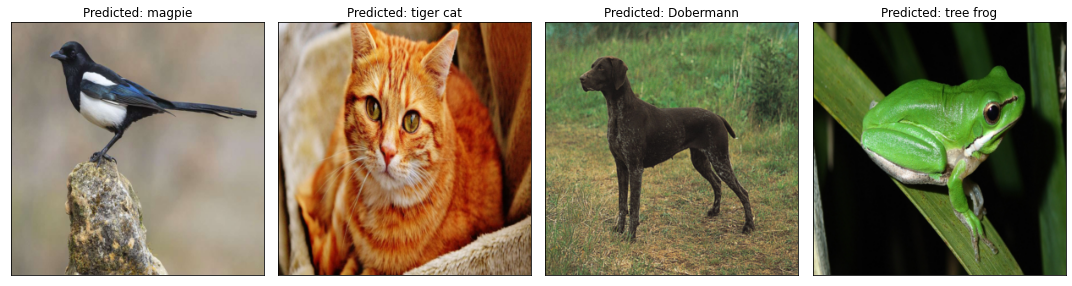

In [29]:
# load inception model 
model = inception_v3(pretrained=True) 
# set to eval, we don't want to modify it
model.eval()

# run the images through the model
output = model(imgs)
pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for ax, img, p in zip(axes, imgs, pred):
    ax.imshow(np.transpose(img.detach(), (1,2,0)))
    ax.set_title(f"Predicted: {labels[p]}")
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()

In [32]:
# prepare loss function for the method
loss = nn.CrossEntropyLoss()

# eps parameter for the FGSM
eps = 0.2

# inputs need to have gradients enabled!
imgs.requires_grad = True

# run the model and calculate the loss
outputs = model(imgs)
cost = loss(outputs, pred)

# get input gradients
grad = torch.autograd.grad(cost, imgs, create_graph=False)[0]

# FGSM 
adv_imgs = imgs + eps * grad.sign()
# clamp to the image range
adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
# save gradients for visualisation
grads = torch.clamp(grad.sign(), min=0, max=1).detach()

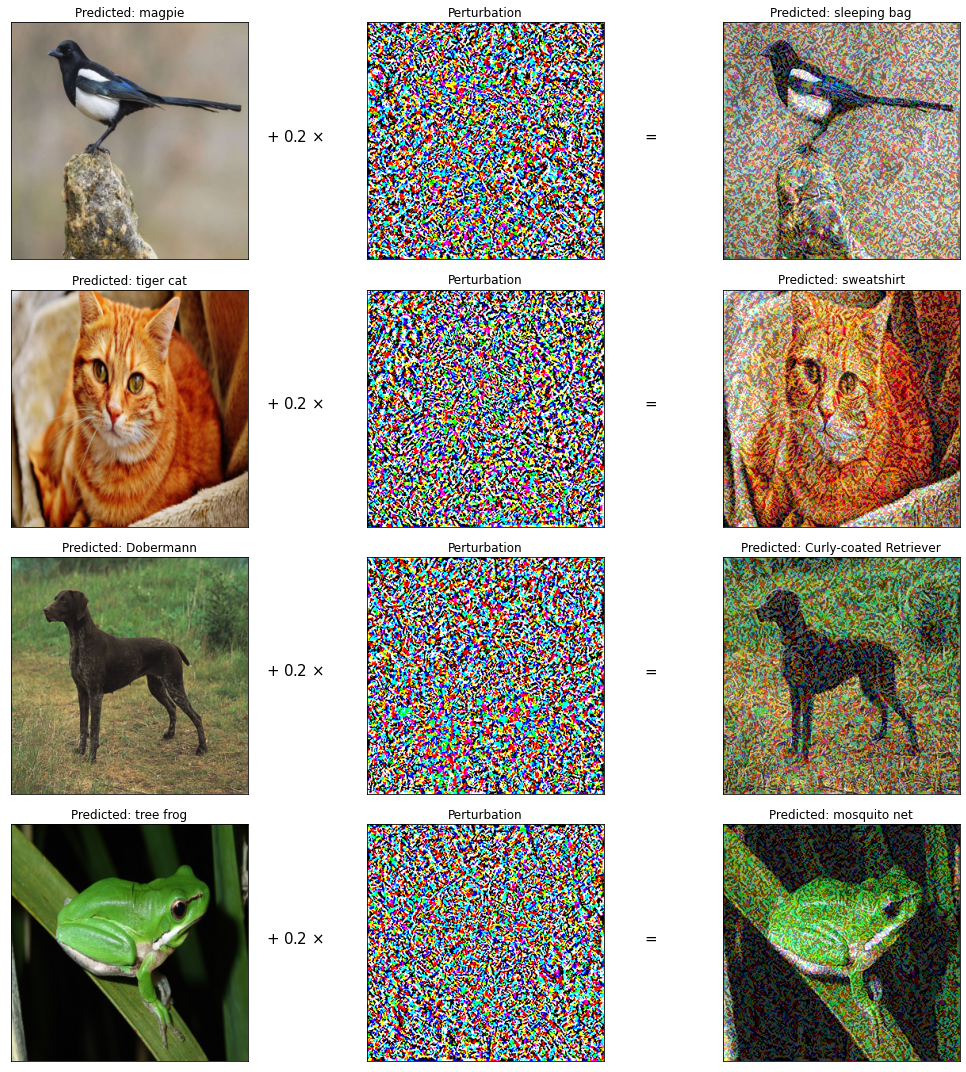

In [33]:
# run the advesarial samples through the network
output = model(adv_imgs)
adv_pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for row, img, adv, p, adv_p, g in zip(axes, imgs, adv_imgs, pred, adv_pred, grads):
    row[0].imshow(np.transpose(img.detach(), (1,2,0)))
    row[0].set_title(f"Predicted: {labels[p]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    
    row[1].imshow(np.transpose(g, (1,2,0)))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    row[2].imshow(np.transpose(adv.detach(), (1,2,0)))
    row[2].set_title(f"Predicted: {labels[adv_p]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
fig.tight_layout()

### Zadanie 3. Przykłady Adwersarialne (2 pkt.)
1. Zobacz dla jakiego $\epsilon$ metoda FGSM zmieni predykcje dla Sroki z powyższego przykładu.
2. Zastosuj metodę FGSM dla swojego modelu i 4 losowych przykładów z CIFAR10 tak aby uzyskać wizualizacje podobną do powyższej.

`HINT`: Normalizacja, której normalnie używamy sprawia, że obrazki wychodzą poza typowe $[0, 1]$, można rozwiązać ten problem na dwa sposoby: <br> 1) "odwrócić" normalizację znając użyte średnią i odchylenie standardowe, <br> 2) nie używać normalizacji.

In [ ]:
#w powyższym przykładzie wystarczyło zmienić 0.02 na 0.2, żeby zmienić predykcję sroki

Files already downloaded and verified


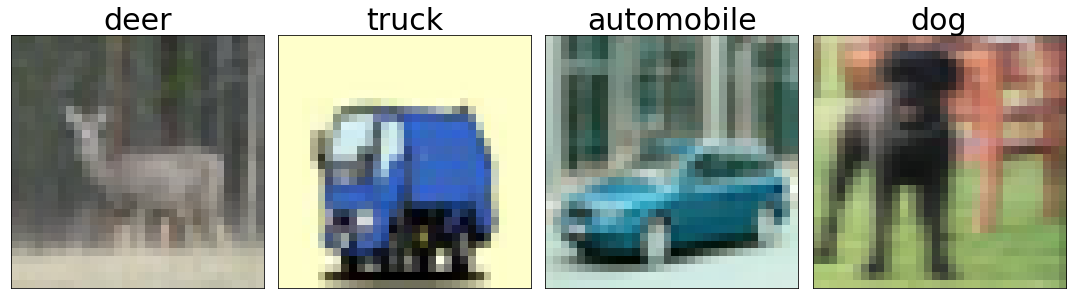

In [39]:
# tutaj załaduj 4 losowe przykłady ze zbioru testowego, uważaj na normalizację!
dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for i, ax in enumerate(axes):
    ax.imshow(np.transpose(x[i], (1, 2, 0)))
    ax.set_title(f"{dataset.classes[y[i]]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()

In [42]:
#tu znowu nasz model uczymy
transforms = Compose(
    [ToTensor(),
     Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=transforms)

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=transforms)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

model_s = CNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model_s.parameters(), lr=0.001, momentum=0.9)
epochs = 15

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss_train = 0.0
    num_batches_train = 0
    running_loss_test = 0.0
    num_batches_test = 0
    running_corrects = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model_s(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item()
        num_batches_train += 1
    with torch.no_grad():
      for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_s(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        running_loss_test += loss.item()
        num_batches_test += 1
        running_corrects += torch.sum(preds == labels.data)
        
    print("Epoch {0} train loss: {1:.3f}".format(epoch + 1, running_loss_train / num_batches_train))
    print("Epoch {0} test loss: {1:.3f}".format(epoch + 1, running_loss_test / num_batches_test))
    print("Epoch {0} test acc: {1:.3f}".format(epoch + 1, running_corrects / num_batches_test))

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1 train loss: 2.300
Epoch 1 test loss: 2.293
Epoch 1 test acc: 17.752
Epoch 2 train loss: 2.261
Epoch 2 test loss: 2.176
Epoch 2 test acc: 26.793
Epoch 3 train loss: 2.046
Epoch 3 test loss: 1.940
Epoch 3 test acc: 39.427
Epoch 4 train loss: 1.879
Epoch 4 test loss: 1.806
Epoch 4 test acc: 44.977
Epoch 5 train loss: 1.732
Epoch 5 test loss: 1.661
Epoch 5 test acc: 50.675
Epoch 6 train loss: 1.627
Epoch 6 test loss: 1.584
Epoch 6 test acc: 54.504
Epoch 7 train loss: 1.563
Epoch 7 test loss: 1.536
Epoch 7 test acc: 56.926
Epoch 8 train loss: 1.517
Epoch 8 test loss: 1.488
Epoch 8 test acc: 59.458
Epoch 9 train loss: 1.476
Epoch 9 test loss: 1.459
Epoch 9 test acc: 60.918
Epoch 10 train loss: 1.442
Epoch 10 test loss: 1.419
Epoch 10 test acc: 62.545
Epoch 11 train loss: 1.405
Epoch 11 test loss: 1.375
Epoch 11 test acc: 65.164
Epoch 12 train loss: 1.374
Epoch 12 test loss: 1.343
Epoch 12 test acc: 66.923
Epoch 13 train loss: 1.347
Epoch 13 test loss: 1.333
Epoch 13 test acc: 66.931


In [50]:
# tutaj zastosuj metode FGSM do wygenerowania przykładów adwersarialnych

# prepare loss function for the method
loss = nn.CrossEntropyLoss()

# eps parameter for the FGSM
eps = 0.02

# inputs need to have gradients enabled!
print(x.requires_grad)

# run the model and calculate the loss
x = x.to(device)
y = y.to(device)
outputs = model_s(x)
cost = loss(outputs, y)

# get input gradients
grad = torch.autograd.grad(cost, x, create_graph=False)[0]

# FGSM 
adv_x = x + eps * grad.sign()
# clamp to the image range
adv_x = torch.clamp(adv_x, min=0, max=1)
# save gradients for visualisation
grads = torch.clamp(grad.sign(), min=0, max=1)

True


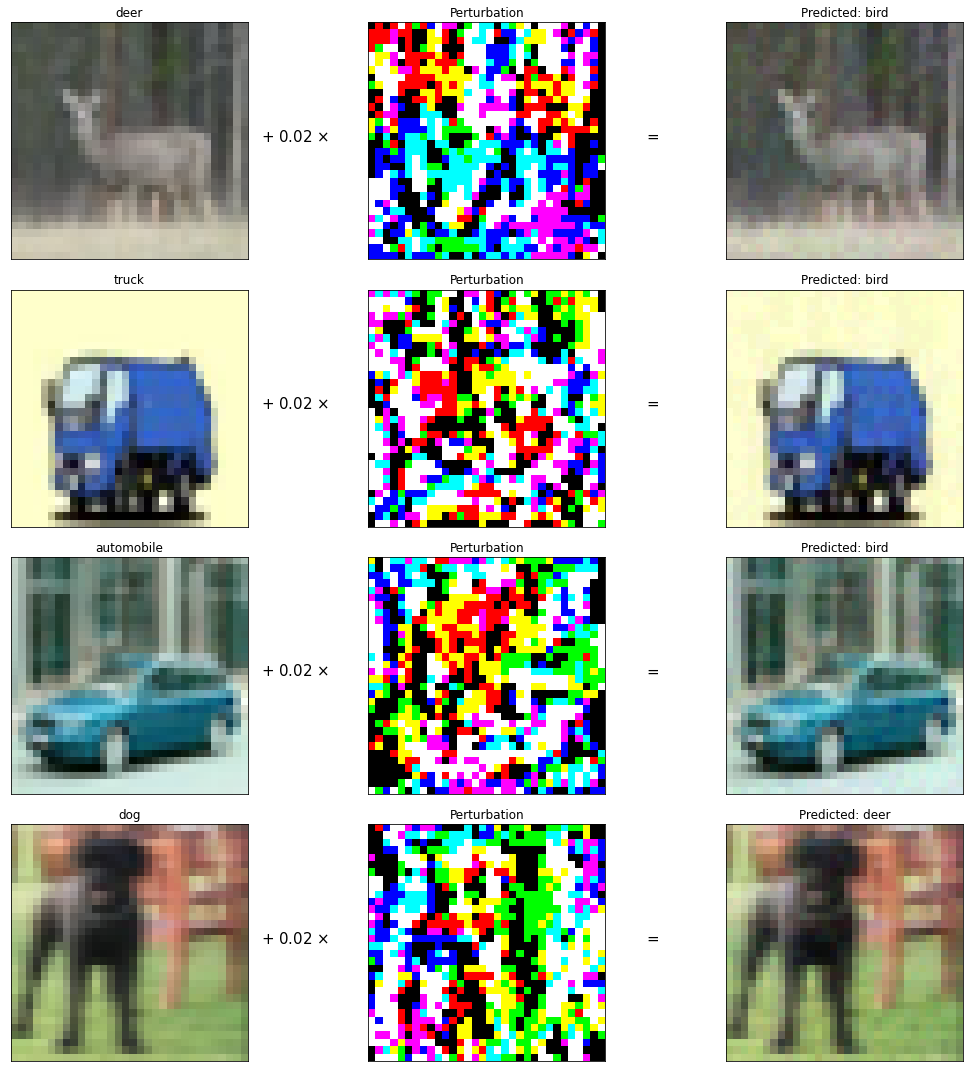

In [58]:
# tutaj przetestuj swój model i użyj wizualizacji z powyższego przykładu
# run the advesarial samples through the network
output = model_s(adv_x)
adv_pred = torch.argmax(output, 1)




# visualisation
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for row, x1, advx, p, adv_p, g in zip(axes, x, adv_x, y, adv_pred, grads):
    row[0].imshow(np.transpose(x1.cpu().detach(), (1,2,0)))
    row[0].set_title(f"{dataset.classes[p]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    
    row[1].imshow(np.transpose(g.cpu(), (1,2,0)))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    row[2].imshow(np.transpose(advx.cpu().detach(), (1,2,0)))
    row[2].set_title(f"Predicted: {dataset.classes[adv_p]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
fig.tight_layout()